In [44]:
import os
import cv2

# Define the dataset path
dataset_path = "dataset"

# Count images in each class
healthy_count = len(os.listdir(os.path.join(dataset_path, "Strawberry__healthy")))
unhealthy_count = len(os.listdir(os.path.join(dataset_path, "Strawberry___Leaf_scorch")))

print(f"Healthy Images: {healthy_count}")
print(f"Unhealthy Images: {unhealthy_count}")

# Automatically get image size
categories = ["Strawberry__healthy", "Strawberry___Leaf_scorch"]

for category in categories:
    category_path = os.path.join(dataset_path, category)
    first_image = next(iter(os.listdir(category_path)), None)

    if first_image:
        img_path = os.path.join(category_path, first_image)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, channels = img.shape
            print(f"Image size: {width}x{height}, Channels: {channels}")

# Define image size dynamically
IMG_SIZE = (width, height)
print(f"Using Image Size: {IMG_SIZE}")


Healthy Images: 186
Unhealthy Images: 1110
Image size: 256x256, Channels: 3
Image size: 256x256, Channels: 3
Using Image Size: (256, 256)


In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

# Data augmentation to improve model generalization
datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Load training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    classes=['Strawberry__healthy', 'Strawberry___Leaf_scorch']
)

# Load validation data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=True,
    classes=['Strawberry__healthy', 'Strawberry___Leaf_scorch']
)

# Print class mapping
print("Class indices:", train_generator.class_indices)


Found 1038 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Class indices: {'Strawberry__healthy': 0, 'Strawberry___Leaf_scorch': 1}


In [46]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load EfficientNetB0 as the base model
base_model = EfficientNetB0(input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze pretrained layers

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,213,668
Trainable params: 164,097
Non-trainable params: 4,049,571
______________________________________

In [47]:
from sklearn.utils import class_weight
import numpy as np 
import time  

start_time = time.time()

# Compute class weights dynamically
labels = [0] * unhealthy_count + [1] * healthy_count  # 0 = unhealthy, 1 = healthy
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weights_dict)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights_dict  # Balance the training
)

end_time = time.time() 
total_time = end_time - start_time 
print(f"\nTotal Training time: {total_time:.2f} seconds. {total_time/60:.2f} minutes")

Computed Class Weights: {0: 0.5837837837837838, 1: 3.4838709677419355}
Epoch 1/5
33/33 [==============================] - 38s 1s/step - loss: 0.5687 - accuracy: 0.8382 - val_loss: 0.6011 - val_accuracy: 0.8571
Epoch 2/5
33/33 [==============================] - 33s 1s/step - loss: 0.4213 - accuracy: 0.8565 - val_loss: 0.5974 - val_accuracy: 0.8571
Epoch 3/5
33/33 [==============================] - 31s 951ms/step - loss: 0.4113 - accuracy: 0.8565 - val_loss: 0.5580 - val_accuracy: 0.8571
Epoch 4/5
33/33 [==============================] - 33s 1s/step - loss: 0.4089 - accuracy: 0.8565 - val_loss: 0.5306 - val_accuracy: 0.8571
Epoch 5/5
33/33 [==============================] - 33s 986ms/step - loss: 0.4019 - accuracy: 0.8565 - val_loss: 0.5929 - val_accuracy: 0.8571


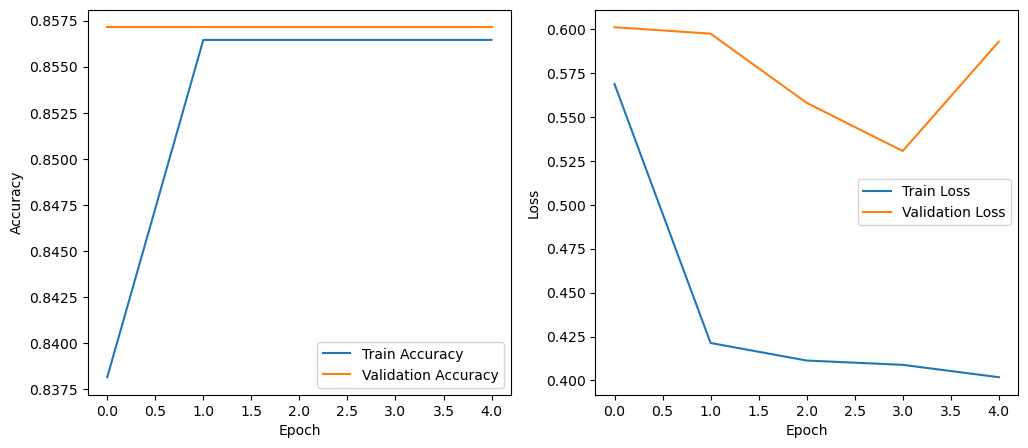

In [48]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [51]:
import random
import os 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image 

# Base directory where split data is stored
base_dir = "dataset"

# Available categories  # Training and validation sets
categories = ["Strawberry__healthy", "Strawberry___Leaf_scorch"]

def get_random_image():
    """Selects a random image from one of the four datasets and returns its full path."""
     
    category = random.choice(categories)  
    
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    if not images:
        return None 
    random_image = random.choice(images)
    return os.path.join(category_path, random_image)

# Function to predict an image and display results
def predict_image(img_path):
    img_name = os.path.basename(img_path)  # Extract image name

    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions

    # Make prediction
    prediction = model.predict(img_array)[0][0]  # Get single prediction value

    # Determine class based on threshold
    label = "Unhealthy" if prediction > 0.5 else "Healthy"

    # Print results
    print(f"Image: {img_name}")
    print(f"Prediction Value: {prediction:.4f}")
    print(f"Class: {label}")

    # Show the image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{img_name}\n{label} ({prediction:.4f})")
    plt.show()


1/1 [==============================] - 0s 65ms/step
Image: e92b2852-5cad-4873-a444-67cd48aac7a7___RS_L.Scorch 0848.JPG
Prediction Value: 0.9825
Class: Unhealthy


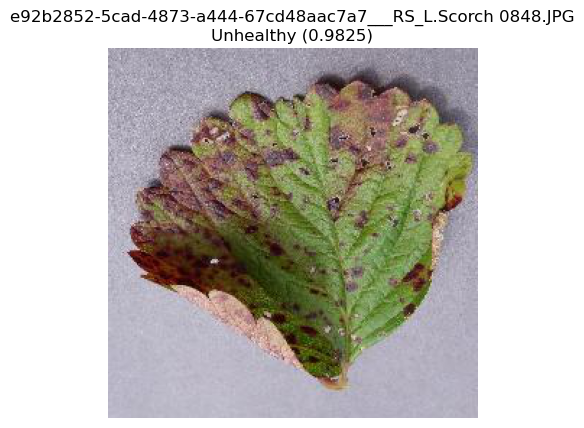

1/1 [==============================] - 0s 58ms/step
Image: 2a3f18fd-758e-493f-86c4-cc8edf18b533___RS_HL 1901.JPG
Prediction Value: 0.9825
Class: Unhealthy


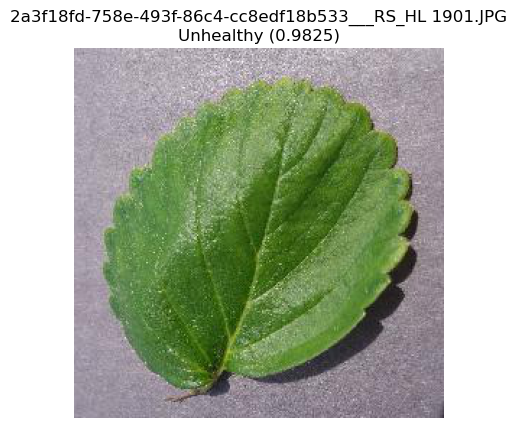

1/1 [==============================] - 0s 58ms/step
Image: f7840195-f040-49fe-a2d7-ddfcf0583df3___RS_L.Scorch 1039.JPG
Prediction Value: 0.9824
Class: Unhealthy


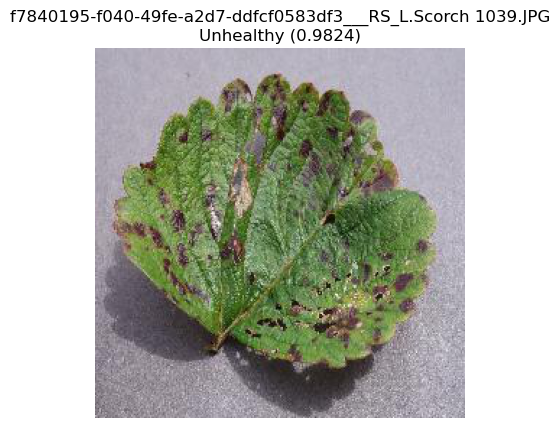

1/1 [==============================] - 0s 59ms/step
Image: 30d8e2ff-ae19-4d1b-be24-cb14e131eadc___RS_L.Scorch 1344.JPG
Prediction Value: 0.9824
Class: Unhealthy


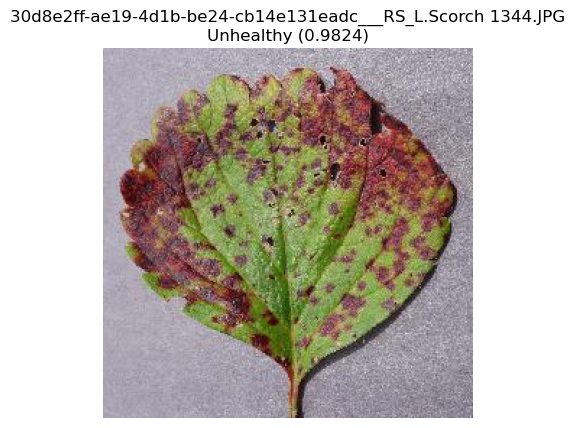

1/1 [==============================] - 0s 58ms/step
Image: 8e704613-f271-417f-8d8a-8b510a327a77___RS_L.Scorch 1398.JPG
Prediction Value: 0.9824
Class: Unhealthy


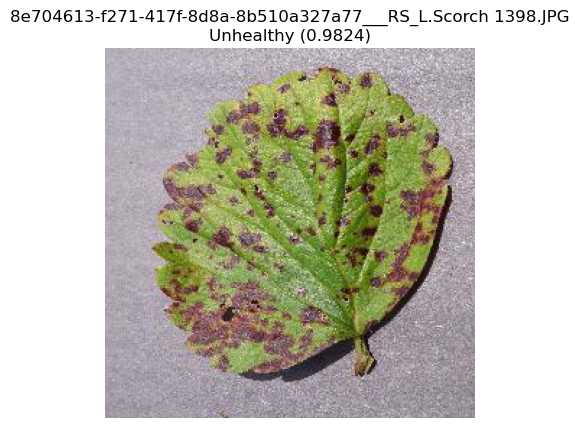

1/1 [==============================] - 0s 68ms/step
Image: 16cb49b2-8d1b-4a66-95fa-9487aa0ba8f1___RS_HL 1665.JPG
Prediction Value: 0.9824
Class: Unhealthy


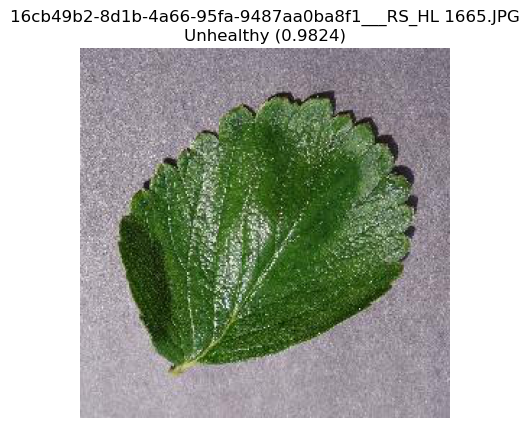

1/1 [==============================] - 0s 71ms/step
Image: 5f13420e-16bb-4aa8-9869-051e0b937ec1___RS_HL 4543.JPG
Prediction Value: 0.9824
Class: Unhealthy


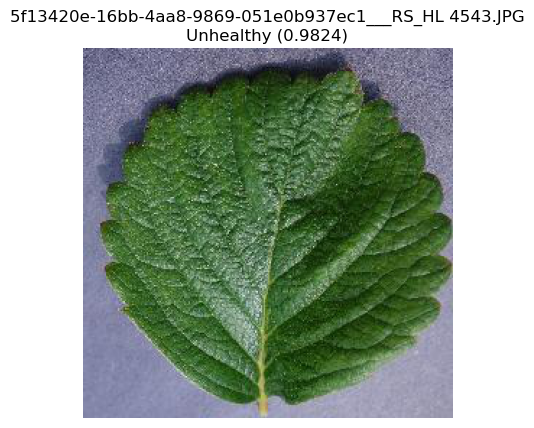

1/1 [==============================] - 0s 59ms/step
Image: 1d92fcef-79d0-469b-b9b1-71a318505821___RS_HL 4487.JPG
Prediction Value: 0.9825
Class: Unhealthy


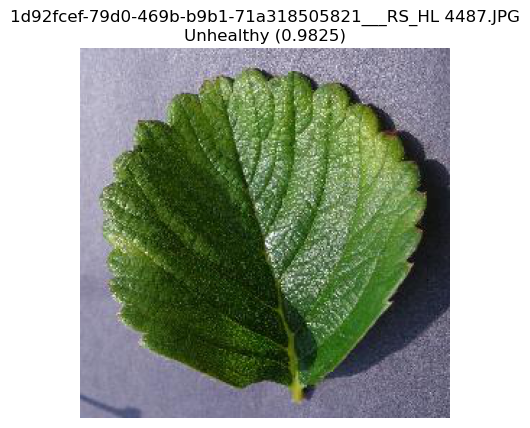

1/1 [==============================] - 0s 57ms/step
Image: 4b9e296e-f995-4632-976b-7cd15862eea0___RS_HL 1777.JPG
Prediction Value: 0.9825
Class: Unhealthy


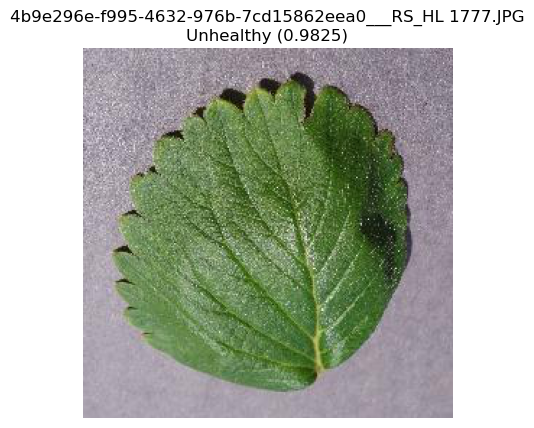

1/1 [==============================] - 0s 55ms/step
Image: 2e738c4c-8d5c-4c1d-91ad-52dfa3e4ec1f___RS_HL 1768.JPG
Prediction Value: 0.9825
Class: Unhealthy


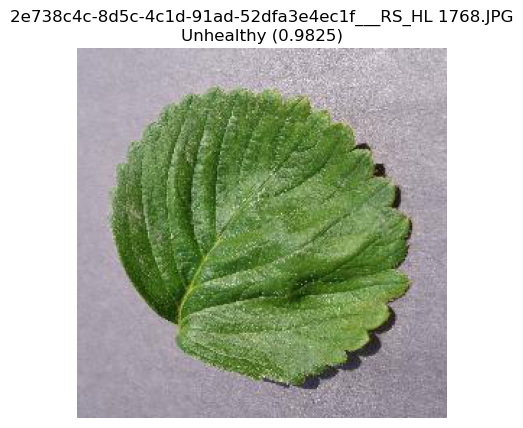

1/1 [==============================] - 0s 54ms/step
Image: c37c8b9a-81f2-4f49-8f57-0fb275845a5f___RS_L.Scorch 1501.JPG
Prediction Value: 0.9824
Class: Unhealthy


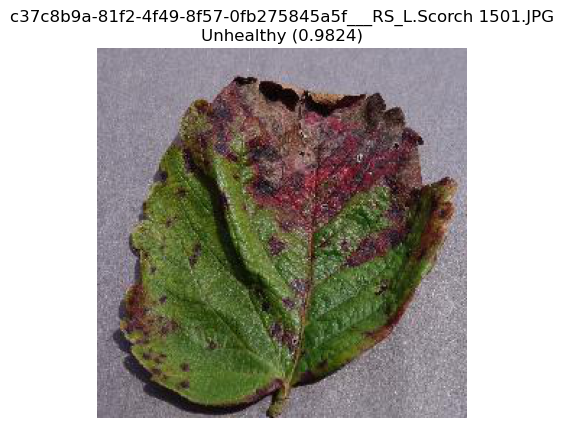

1/1 [==============================] - 0s 68ms/step
Image: cee45ae3-03d6-41fb-aa2b-35a2ec20d8fb___RS_L.Scorch 1239.JPG
Prediction Value: 0.9824
Class: Unhealthy


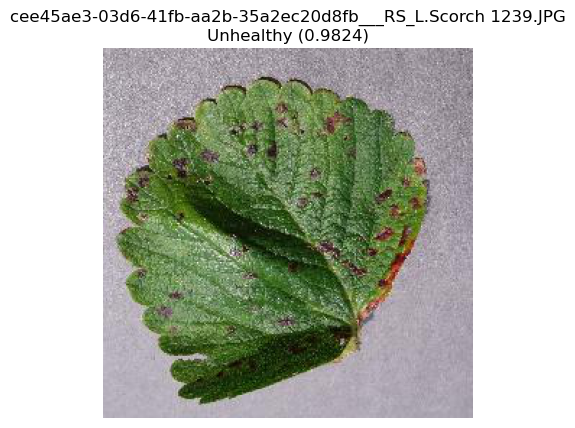

1/1 [==============================] - 0s 65ms/step
Image: 58265359-4fa0-458c-9c5f-5774d94b3088___RS_HL 1737.JPG
Prediction Value: 0.9824
Class: Unhealthy


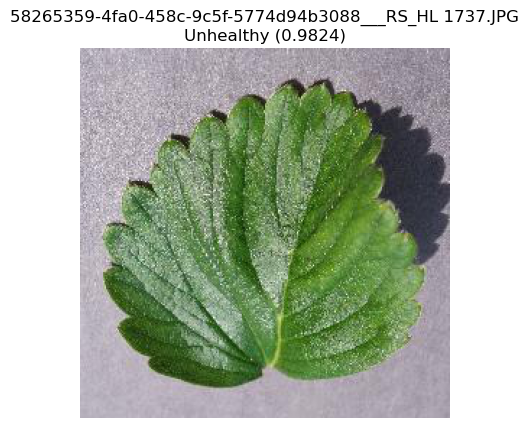

1/1 [==============================] - 0s 57ms/step
Image: c1bed3be-64c9-403b-b633-17c82ae5f371___RS_L.Scorch 0164.JPG
Prediction Value: 0.9824
Class: Unhealthy


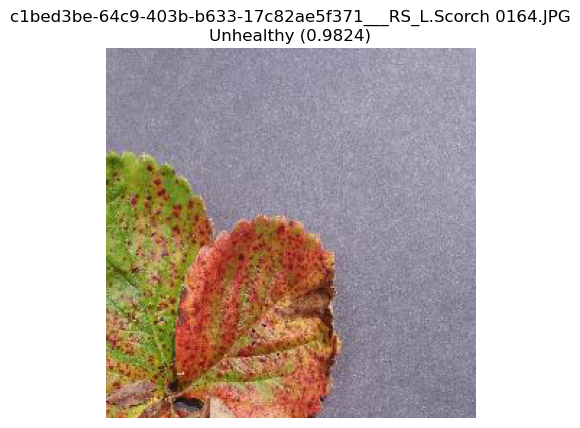

1/1 [==============================] - 0s 58ms/step
Image: 35207f57-999d-4698-94aa-2d8c4efb230f___RS_HL 4726.JPG
Prediction Value: 0.9825
Class: Unhealthy


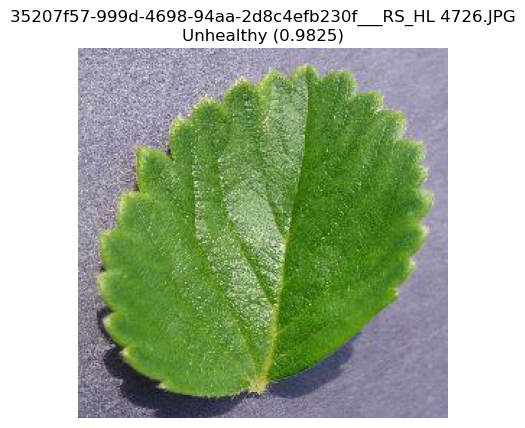

1/1 [==============================] - 0s 66ms/step
Image: ef848b5e-8c3c-436c-bf74-c3c6008adaf6___RS_L.Scorch 1351.JPG
Prediction Value: 0.9824
Class: Unhealthy


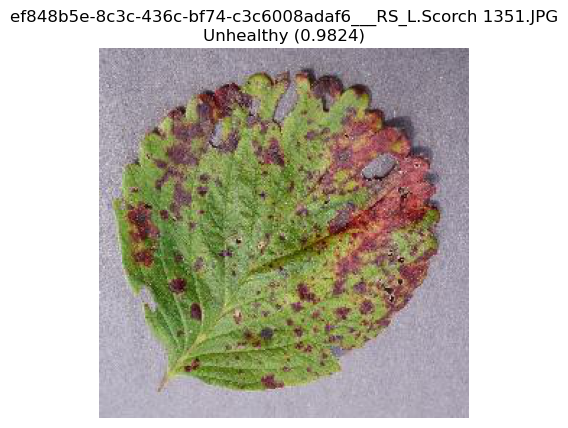

1/1 [==============================] - 0s 66ms/step
Image: 1d9056b1-898f-443c-afa7-f57b73831f7b___RS_L.Scorch 1406.JPG
Prediction Value: 0.9825
Class: Unhealthy


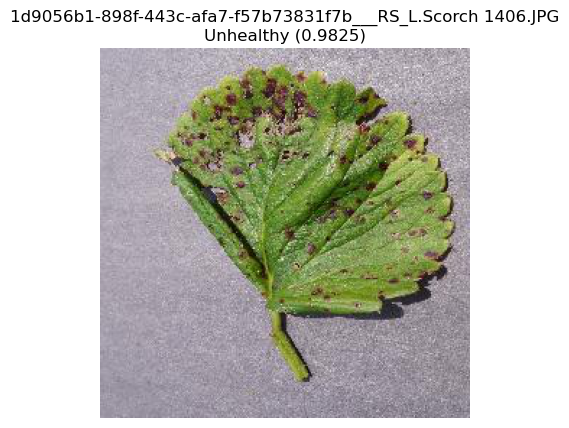

1/1 [==============================] - 0s 67ms/step
Image: c626dd6f-33c3-4b39-8c25-d8954db4ae11___RS_L.Scorch 0850.JPG
Prediction Value: 0.9825
Class: Unhealthy


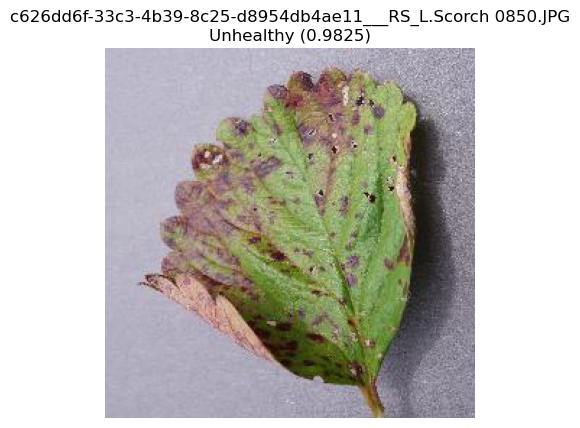

1/1 [==============================] - 0s 57ms/step
Image: 24ed4d2a-098e-4313-b131-cf5ca2b49ab2___RS_L.Scorch 1602.JPG
Prediction Value: 0.9824
Class: Unhealthy


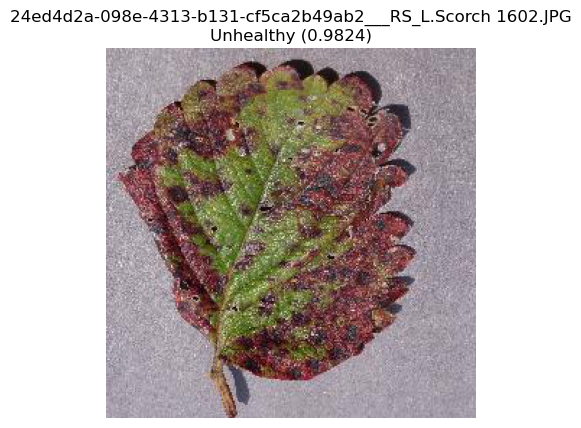

1/1 [==============================] - 0s 53ms/step
Image: d25ad1a1-3d38-489b-9ecb-34130b89fe9b___RS_L.Scorch 1103.JPG
Prediction Value: 0.9825
Class: Unhealthy


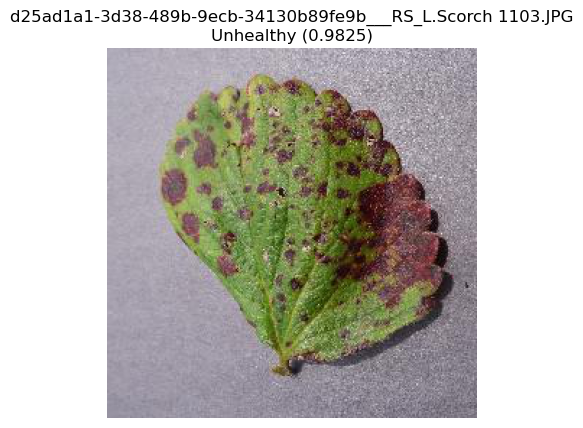

In [52]:
tests = 20
for i in range(tests): 
    predict_image("" + get_random_image())